In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data

This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'

In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    file_name = 'data1/' + file_name[41:]
    
    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Grouping all texts files
A dataframe is first created to keep individual files at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#list of the file names
files_list = os.listdir('data1')

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [11]:
# for verification purposes later, count the nr of characters for each content
sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
sources['file_len'].sum()

1779770

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# variable containing all documents together
all_texts = ''
for i in range(len(sources)):
  all_texts += sources['file_content'][i]

In [14]:
# check length
len(all_texts)

1779770

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# add new column in df with processed tokens
sources['tokens_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalnum() and len(w) > 3 )])

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['tokens_prep_nostop'] = sources['tokens_prep'].apply(lambda x: [w for w in x if not w in spacy_it_sw])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['tokens_stemmed'] = sources['tokens_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['tokens_lemmatized'] = sources['tokens_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['tokens_lemmatized']

# 2. Topics with LDA

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA


### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# create a human friendly view of term frequency list
# I leave the line below for testing purposes
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1000]]

In [0]:
# list of words and frequency
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [39]:
# sort descending
words_frequency.sort_values(by=['frequency'], ascending=False)[:10]
# frequency is on a per document basis

,word,frequency
38,acqua,7
77,1898,5
7,accordare,3
22,accordare,3
79,abbandonare,2
65,accennare,2
31,agire,2
36,accalcare,2
78,agire,2
80,abbandonare,2


### 2.1.2 TFIDF

In [0]:
# optional
# TFIDF for better performance
# https://en.wikipedia.org/wiki/Tf–idf / 
# https://rare-technologies.com/pivoted-document-length-normalisation/

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 7

This notebook explores the results with Gensim and TFIDF

In [0]:
ldagensim_tfidf = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=numtopics)


In [85]:
ldagensim_tfidf.print_topics()

[(0,
  '0.000*"cardinale" + 0.000*"serbia" + 0.000*"conclave" + 0.000*"diamond" + 0.000*"xiii" + 0.000*"black" + 0.000*"leone" + 0.000*"papa" + 0.000*"salmone" + 0.000*"pescatore"'),
 (1,
  '0.000*"cardinale" + 0.000*"marconi" + 0.000*"mayor" + 0.000*"lira" + 0.000*"scioperare" + 0.000*"cleveland" + 0.000*"venezia" + 0.000*"ebreo" + 0.000*"produzione" + 0.000*"squadrare"'),
 (2,
  '0.000*"cardinale" + 0.000*"marconi" + 0.000*"immigrare" + 0.000*"jose" + 0.000*"latino" + 0.000*"belgrado" + 0.000*"mafia" + 0.000*"emigrare" + 0.000*"tolstoi" + 0.000*"cleveland"'),
 (3,
  '0.000*"cardinale" + 0.000*"tolstoi" + 0.000*"xiii" + 0.000*"padrona" + 0.000*"miniera" + 0.000*"pontefice" + 0.000*"dittatura" + 0.000*"papa" + 0.000*"salma" + 0.000*"roosevelt"'),
 (4,
  '0.000*"text" + 0.000*"available" + 0.000*"lavoratore" + 0.000*"maggio" + 0.000*"ebreo" + 0.000*"marconi" + 0.000*"cardinale" + 0.000*"roso" + 0.000*"festa" + 0.000*"borghesia"'),
 (5,
  '0.000*"cardinale" + 0.000*"conclave" + 0.000*"te

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

In [46]:
coherence_model_ldagensim_tfidf = CoherenceModel(model=ldagensim_tfidf, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim_tfidf = coherence_model_ldagensim_tfidf.get_coherence()
print('\nCoherence Score LDA Gensim TFIDF: ', coherence_ldagensim_tfidf)


Coherence Score LDA Gensim TFIDF:  0.4676993515257735


## 2.4 Coherence and number of topics

In [0]:
# Function to calculate optimal number of topics for LDA Gensim
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# the cell below runs the function set just above and can take a long time to run 
%%capture
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=lemmatized_corpus, start=2, limit=40, step=1)

In [51]:
# Store the value of the coherence scores for plotting later
topics_nr = []
topics_scores = []
limit=20; start=2; step=1;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    topics_nr.append(str(m))
    topics_scores.append(round(cv, 4))
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2895
Num Topics = 3  has Coherence Value of 0.323
Num Topics = 4  has Coherence Value of 0.3727
Num Topics = 5  has Coherence Value of 0.4415
Num Topics = 6  has Coherence Value of 0.4855
Num Topics = 7  has Coherence Value of 0.4915
Num Topics = 8  has Coherence Value of 0.4787
Num Topics = 9  has Coherence Value of 0.4728
Num Topics = 10  has Coherence Value of 0.4985
Num Topics = 11  has Coherence Value of 0.5345
Num Topics = 12  has Coherence Value of 0.5187
Num Topics = 13  has Coherence Value of 0.5302
Num Topics = 14  has Coherence Value of 0.5264
Num Topics = 15  has Coherence Value of 0.5215
Num Topics = 16  has Coherence Value of 0.5004
Num Topics = 17  has Coherence Value of 0.5296
Num Topics = 18  has Coherence Value of 0.5301
Num Topics = 19  has Coherence Value of 0.5403


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

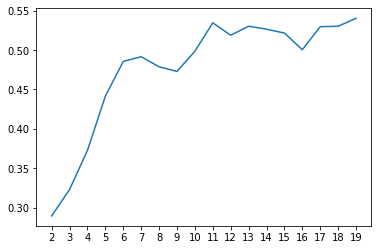

In [53]:
plt.plot(topics_nr, topics_scores)

## 2.5 Visualize the topics

In [0]:
# Plotting tools
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 7 topics
%%capture
selected_model = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=7)

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus_tfidf, id2word)

In [58]:
# Not all functionalities will work as the data has already been pre-processed with TFIDF
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.001742 -0.000310       1        1  36.910435
3     -0.000048 -0.000710       2        1  16.912800
6      0.000181  0.000988       3        1  13.849370
5     -0.000752 -0.000917       4        1  12.537451
4     -0.000501  0.000594       5        1   9.622878
2     -0.000108  0.000291       6        1   5.148514
0     -0.000514  0.000064       7        1   5.018549, topic_info=             Term      Freq     Total Category  logprob  loglift
2854    cardinale  0.000000  0.000000  Default  30.0000  30.0000
23562   available  0.000000  0.000000  Default  29.0000  29.0000
23563        text  0.000000  0.000000  Default  28.0000  28.0000
509         leone  0.000000  0.000000  Default  27.0000  27.0000
4109     conclave  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
4430   california  0.007386  0.190434   Topic7  -9.7548  -0.2577
5823   scioperare  0.007182  0.159829   Topic7  -9.7828  -0.1104
2854    cardinale  0.007622  0.373987   Topic7  -9.7234  -0.9012
4876     stagione  0.006934  0.120110   Topic7  -9.8179   0.1401
1580      marconi  0.007212  0.227555   Topic7  -9.7786  -0.4596

[388 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 6, 5, 3, 1])

# Topic distribution

## 1. Distribution per topic and per document

In [0]:
%%capture
ldamodel = models.LdaModel(corpus_tfidf, num_topics=7, id2word = id2word, minimum_probability=0)

In [0]:
distribution = pd.DataFrame(index=[i for i in range(len(corpus_tfidf))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
for i in range(len(corpus_tfidf)):
  row = [list(j)[1] for j in ldamodel[corpus_tfidf[i]]] 
  distribution.loc[i] = row

In [0]:
# add file name
distribution.insert(0, 'document_path', sources['file_name'])

In [107]:
distribution

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,sn85066408_1903-06-06_ed-1_seq-1_ocr.txt,0.00499716,0.00498463,0.00498443,0.00498277,0.00499705,0.970076,0.00497752
1,sn85066408_1903-05-09_ed-1_seq-1_ocr.txt,0.967913,0.00534547,0.00534436,0.00534388,0.00535838,0.00535526,0.00533959
2,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.517596,0.4586,0.00475932,0.00476218,0.00477014,0.00475753,0.00475433
3,sn85066408_1903-06-26_ed-1_seq-1_ocr.txt,0.0048507,0.00483825,0.00483992,0.00483687,0.970965,0.00483661,0.00483307
4,sn85066408_1903-06-17_ed-1_seq-1_ocr.txt,0.478805,0.00490384,0.00490251,0.496678,0.0049136,0.00490024,0.00489694
...,...,...,...,...,...,...,...,...
95,sn85066408_1903-07-28_ed-1_seq-1_ocr.txt,0.965865,0.00569355,0.00568965,0.00568748,0.00569623,0.00568657,0.00568183
96,sn85066408_1903-05-23_ed-1_seq-1_ocr.txt,0.00490888,0.00490674,0.0049104,0.00490524,0.970557,0.00490869,0.00490317
97,sn85066408_1903-05-26_ed-1_seq-1_ocr.txt,0.0056746,0.00566501,0.00566447,0.00566404,0.966008,0.0056629,0.0056609
98,sn85066408_1903-06-16_ed-1_seq-1_ocr.txt,0.00971437,0.00521802,0.00521804,0.00521567,0.177931,0.00521683,0.791487


## 2. Distribution per topic for the whole corpus

In [98]:
for i in range(len(distribution.columns)):
  topic_weight = round(sum(distribution.iloc[:,i]),2)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldagensim_tfidf.print_topics()[i][1]
  print( f'terms: {topic} ') 
  print( )

topic 0: 18.37%
terms: 0.000*"cardinale" + 0.000*"serbia" + 0.000*"conclave" + 0.000*"diamond" + 0.000*"xiii" + 0.000*"black" + 0.000*"leone" + 0.000*"papa" + 0.000*"salmone" + 0.000*"pescatore" 

topic 1: 14.34%
terms: 0.000*"cardinale" + 0.000*"marconi" + 0.000*"mayor" + 0.000*"lira" + 0.000*"scioperare" + 0.000*"cleveland" + 0.000*"venezia" + 0.000*"ebreo" + 0.000*"produzione" + 0.000*"squadrare" 

topic 2: 11.11%
terms: 0.000*"cardinale" + 0.000*"marconi" + 0.000*"immigrare" + 0.000*"jose" + 0.000*"latino" + 0.000*"belgrado" + 0.000*"mafia" + 0.000*"emigrare" + 0.000*"tolstoi" + 0.000*"cleveland" 

topic 3: 8.56%
terms: 0.000*"cardinale" + 0.000*"tolstoi" + 0.000*"xiii" + 0.000*"padrona" + 0.000*"miniera" + 0.000*"pontefice" + 0.000*"dittatura" + 0.000*"papa" + 0.000*"salma" + 0.000*"roosevelt" 

topic 4: 36.51%
terms: 0.000*"text" + 0.000*"available" + 0.000*"lavoratore" + 0.000*"maggio" + 0.000*"ebreo" + 0.000*"marconi" + 0.000*"cardinale" + 0.000*"roso" + 0.000*"festa" + 0.000*"